In [ ]:
# ATMS 305, Fall 2024 -- Lab25: Downburst
# Here you plot and interrogate a simulation of a downburst.

In [1]:
# >> A. IMPORT
#  ... you'll need numpy, matplotlib.pyplot, and xarray
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
# >> B. GET and UNZIP THE DOWNBURST DATA FILES
#
# This is a simulation of a dry downburst, in 3-D
#   1. !wget this file: rfd.atmos.uiuc.edu/305/downburst.zip
#   2. unzip everything with:  !unzip -o downburst.zip
#   3. save space: delete the .zip file:  !rm downburst.zip
!wget -q -N rfd.atmos.uiuc.edu/305/downburst.zip
!unzip -o downburst.zip
!rm downburst.zip

Archive:  downburst.zip
  inflating: wrfout_d01_0001-01-01_00_00_00.nc  
  inflating: wrfout_d01_0001-01-01_00_01_00.nc  
  inflating: wrfout_d01_0001-01-01_00_02_00.nc  
  inflating: wrfout_d01_0001-01-01_00_03_00.nc  
  inflating: wrfout_d01_0001-01-01_00_04_00.nc  
  inflating: wrfout_d01_0001-01-01_00_05_00.nc  
  inflating: wrfout_d01_0001-01-01_00_06_00.nc  
  inflating: wrfout_d01_0001-01-01_00_07_00.nc  
  inflating: wrfout_d01_0001-01-01_00_08_00.nc  
  inflating: wrfout_d01_0001-01-01_00_09_00.nc  
  inflating: wrfout_d01_0001-01-01_00_10_00.nc  
  inflating: wrfout_d01_0001-01-01_00_11_00.nc  
  inflating: wrfout_d01_0001-01-01_00_12_00.nc  
  inflating: wrfout_d01_0001-01-01_00_13_00.nc  
  inflating: wrfout_d01_0001-01-01_00_14_00.nc  
  inflating: wrfout_d01_0001-01-01_00_15_00.nc  
  inflating: wrfout_d01_0001-01-01_00_16_00.nc  
  inflating: wrfout_d01_0001-01-01_00_17_00.nc  
  inflating: wrfout_d01_0001-01-01_00_18_00.nc  
  inflating: wrfout_d01_0001-01-01_00_19_00.n

In [4]:
# >> C. OPEN =ALL= DATASETS at ONCE
#
# We've done some work with Xarray for NetCDF data before.
# What's new here: we open all 21 files (21 data times) together.
# Info: https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html#xarray.open_mfdataset
#       https://docs.xarray.dev/en/stable/user-guide/combining.html
#
#   1. Use: DS = xr.open_mfdataset( 'wrfout*.nc', option, option... )
#     a) You need two options, separated by commas:
#     b) Option 1: combine='nested'   ...for when data is split across many files
#     c) Option 2: concat_dim='time'  ...concatenation is on dimension 'time'
#
#   2. See the data content preview by just running "DS"
#
#   The 3-D data includes:
#     a) temp:  temperature
#     b) theta: "potential" temperature perturbation --
#            potential = doesn't change in dry ascent/descent
#     c) pres:  pressure
#     d) u:     east-west/horizontal airflow
#     e) w:     up-down/vertical airflow
#
# CHECK: the 'Dimensions' should say:  time: 21, NX: 45, NY: 89, NZ: 21
# X is west-east, Y is north-south and Z is up/down (so: 21 vertical levels)
# The data is STORED in python as: [time, Z, Y, X]
DS = xr.open_mfdataset('wrfout*.nc', combine='nested', concat_dim='time')
DS

<xarray.Dataset> Size: 36MB
Dimensions:  (time: 21, NX: 45, NY: 89, NZ: 21)
Dimensions without coordinates: time, NX, NY, NZ
Data variables:
    X        (time, NX) float32 4kB dask.array<chunksize=(1, 45), meta=np.ndarray>
    Y        (time, NY) float32 7kB dask.array<chunksize=(1, 89), meta=np.ndarray>
    Z        (time, NZ) float32 2kB dask.array<chunksize=(1, 21), meta=np.ndarray>
    w250     (time, NY, NX) float32 336kB dask.array<chunksize=(1, 89, 45), meta=np.ndarray>
    psfc     (time, NY, NX) float32 336kB dask.array<chunksize=(1, 89, 45), meta=np.ndarray>
    temp     (time, NZ, NY, NX) float32 7MB dask.array<chunksize=(1, 21, 89, 45), meta=np.ndarray>
    theta    (time, NZ, NY, NX) float32 7MB dask.array<chunksize=(1, 21, 89, 45), meta=np.ndarray>
    pres     (time, NZ, NY, NX) float32 7MB dask.array<chunksize=(1, 21, 89, 45), meta=np.ndarray>
    u        (time, NZ, NY, NX) float32 7MB dask.array<chunksize=(1, 21, 89, 45), meta=np.ndarray>
    w        (time, NZ, NY, NX) float32 7MB dask.array<chunksize=(1, 21, 89, 45), meta=np.ndarray>

In [5]:
# >> D. EXAMINE "W" data
#
#   The vertical velocity ('w') data is stored as:  DS.w
#
#   1. Show the 'w' array dimensions with .shape
#
# CHECK: dimensions = time (21 times), Z (21 levels), Y (89 rows), X (45 columns)
DS.w

<xarray.DataArray 'w' (time: 21, NZ: 21, NY: 89, NX: 45)> Size: 7MB
dask.array<concatenate, shape=(21, 21, 89, 45), dtype=float32, chunksize=(1, 21, 89, 45), chunktype=numpy.ndarray>
Dimensions without coordinates: time, NZ, NY, NX
Attributes:
    units:    m/s

Text(0.5, 0.98, 'E. W XY vs. Time')

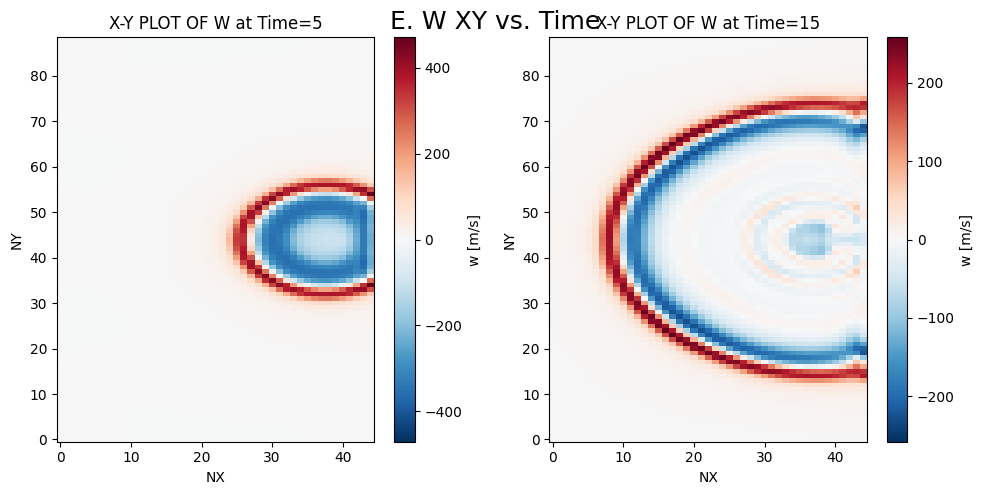

In [7]:
# >> E. PLOT X-Y SLICE of W at Z=200m
#
# > Remember the data is stored with dimensions [T,Z,Y,X]
#
#  Start a 10x5" figure, with 1 row, 2 columns.
#
#  1. Left figure: Plot a X-Y slice of W using DS.w[ ].plot --
#    >> The statement looks like: DS.w[a,b,c,d].plot()
#    a) Set first index inside [] of DS.w[] to be 5 (for file "wrfout05.nc")
#    b) Use 2nd index = 1 (0=surface, 1=200m above ground)
#    c) Use 3rd index = : (for all Y points)
#    d) Use 4th index = : (for all X points; this will be a X-Y plot)
#    e) Append .plot() after closing brace!
#    e) Add title with plt.title:  X-Y PLOT OF W at Time=5
#
#  2. Right figure: Same X-Y plot - later time
#    a) use time index 15 (=file wrfout15.nc)
#    a) add title: X-Y PLOT OF W at Time=15
#
# This syntax is similar to pandas ...  (field.plot())
# Notice how x/y labels and colorbar are done for you!!
#
#  3. Add tight_layout
#
#  4. Add a "suptitle" --
#       https://how2matplotlib.com/matplotlibpyplotsuptitle-function-in-python.html
#    a) change plt.figure(...) to: fig=plt.figure(...)
#    b) somewhere in cell, put: fig.suptitle('E. W XY vs. Time',fontsize=18);
#
# CHECK: colorbar runs -300 ... +300 -- actually cm/s, not m/s
#      : blue is downdraft, red is updraft; cold downburst Starts ~ right edge
#      : it spreads out horizontally by time index 15
#      : xarray/matplotlib adapts the colors automatically (So: scale changes)

fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
DS.w[5, 1, :, :].plot()
plt.title("X-Y PLOT OF W at Time=5")

plt.subplot(1, 2, 2)
DS.w[15, 1, :, :].plot()
plt.title("X-Y PLOT OF W at Time=15")

plt.tight_layout()
fig.suptitle("E. W XY vs. Time", fontsize=18)


Text(0.5, 0.98, 'F. Revised W XY vs. Time')

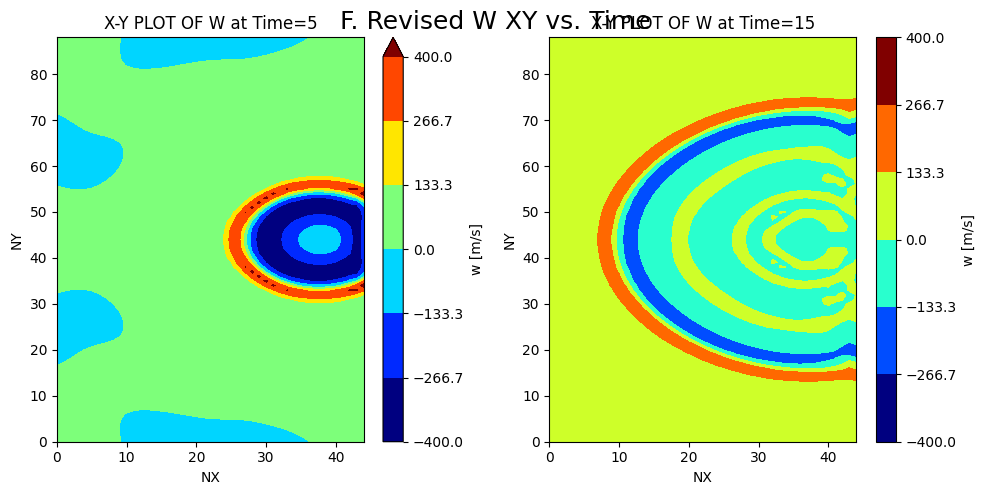

In [14]:
# >> F. REDO: X-Y SLICE of W at Z=200m
#
#  1. Copy code from the last cell here.
#  2. Change DS.w[].plot() to:  DS.w[].plot.contourf()
#       this effectively smoothes out the rough figures above.
#  3. Inside BOTH contourf() statements, add option: vmin=-400,vmax=400
#    a) try it and see, but you could consider adding:  cmap='jet' or 'rainbow'
#    b) colormaps: https://matplotlib.org/stable/gallery/color/colormap_reference.html
#  4. Add titles with plt.title:  X-Y PLOT OF W at Time=5 (or Time=15)
#  5. Add suptitle: 'F. Revised W XY vs. Time'
fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
DS.w[5, 1, :, :].plot.contourf(vmin=-400, vmax=400, cmap='jet')  # Use contourf
plt.title("X-Y PLOT OF W at Time=5")

plt.subplot(1, 2, 2)
DS.w[15, 1, :, :].plot.contourf(vmin=-400, vmax=400, cmap='jet')
plt.title("X-Y PLOT OF W at Time=15")

plt.tight_layout()
fig.suptitle('F. Revised W XY vs. Time', fontsize=18)

Text(0.5, 1.0, 'G: X-T plot of W at 200m')

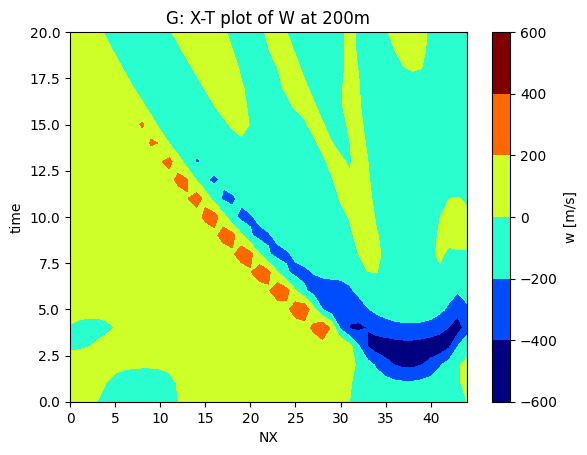

In [15]:
# >> G. PLOT X-T (SPACE-TIME) SLICE of W at Z=200m
#
#  Again: DS.w field
#  1. 1st index is ':' (for all times)
#  2. 2nd index 1      (200m AGL)
#  3. 3rd index 45     (~middle of Y domain)
#  4. 4th index is ':' (for all X)
#  5. add .plot() as before
#        ... if you wish: use plot.contourf() and/or cmap=
#  6. Add title: G: X-T plot of W at 200m
#
#  CHECK: strongest downdrafts near time '1' are on right side (X ~ 37)
#          ... and they spread to left (west) at later times.

DS.w[:, 1, 45, :].plot.contourf(cmap='jet')
plt.title('G: X-T plot of W at 200m')

Text(0.5, 1.0, 'H: X-Y plot of W with 20 contour levels')

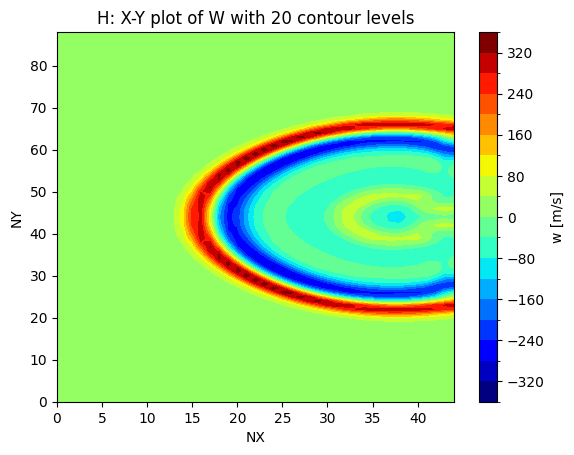

In [17]:
# >> H. X-Y PLOT again but with 20 CONTOUR LEVELS
#
# 1. repeat earlier x-y plot but just one time (time index 10)
# 2. use Z index 1 again (200m AGL)
# 3. use .plot.contourf(levels=20)
# 4. add title: H: X-Y plot of W with 20 contour levels

DS.w[10, 1, :, :].plot.contourf(levels=20, cmap='jet')
plt.title('H: X-Y plot of W with 20 contour levels')

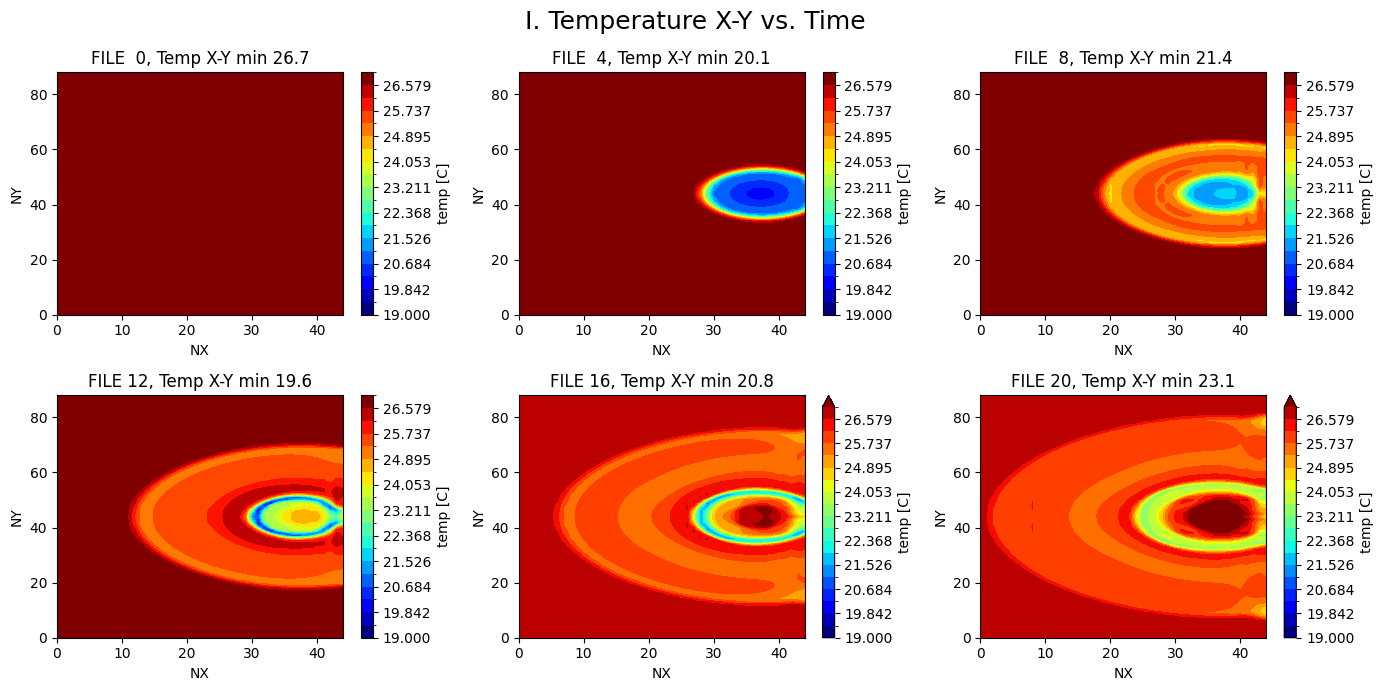

In [26]:
# >> I. 6-PANEL X-Y PLOT of TEMPERATURE
#
#  1. make a larger figsize; I used 14x7"
#
#  2. start a for-loop for time index "n" with values 0, 4, ... 20 (including 20!!!)
#       with interval 4 (we'll use this for-loop variable in DS.temp[] indexing)
#
#  3. In the loop, use plt.subplot(2,3,int(n/4)+1)  ...trust me :)
#
#  4. Make .plot.contourf plots, 20 levels, for DS.temp ... time index "n",
#     2nd (z) index 0 (ground surface), and then :,: for Y and X
#
#  5. Add a title that shows the file number (n) >AND< the min value of this X-Y slice
#     a) for title: use print syntax with np.min(DS.temp[..same indices as plot..])
#        ... use %d for file number, XX.X (that's %4.1f) for np.min() value
#        ... my titles looked like this: FILE 20, Temp X-Y min 23.1
#
#  6. Add suptitle, out of loop: I. Temperature X-Y vs. Time
#
#  7. Finish, out of loop, with tight_layout ... and run this cell!
#
#  8. Notice how the colors change - in plots and colorbar?
#     >NOW< go back and in contourf() add options: ,vmin=19,vmax=27
#     Run again - you're done.
fig = plt.figure(figsize=(14, 7))

for n in range(0, 21, 4):
  plt.subplot(2, 3, int(n/4)+1)
  DS.temp[n, 0, :, :].plot.contourf(levels=20, vmin=19,vmax=27, cmap='jet')
  min_temp = np.min(DS.temp[n, 0, :, :]).values
  plt.title(f"FILE {n:2d}, Temp X-Y min {min_temp:4.1f}")

fig.suptitle('I. Temperature X-Y vs. Time', fontsize=18)
plt.tight_layout()

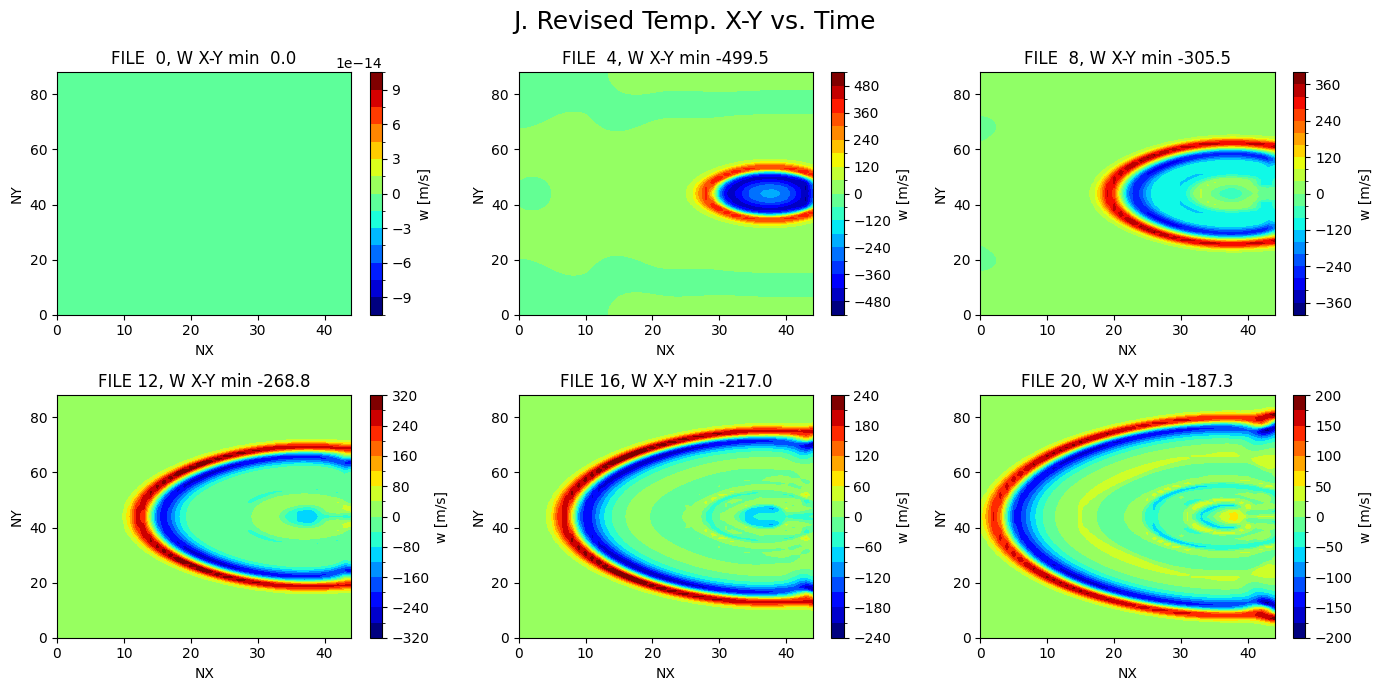

In [28]:
# >> J. 6-PANEL X-Y PLOT of W (Revised)
#
# Repeat last figure but
#   1. do contour plots for DS.w at time n, z level 1 (not zero)
#   2. still use levels=20 in contourf
#   3. don't use vmin= or vmax= for coloring of filled contours
#   4. you pick title but still show file number and np.min of the W slice
#   5. add suptitle: J. Revised Temp. X-Y vs. Time
#   6. use tight_layout again

fig = plt.figure(figsize=(14, 7))

for n in range(0, 21, 4):
  plt.subplot(2, 3, int(n/4)+1)
  DS.w[n, 1, :, :].plot.contourf(levels=20, cmap='jet')
  min_w = np.min(DS.w[n, 1, :, :]).values
  plt.title(f"FILE {n:2d}, W X-Y min {min_w:4.1f}")

fig.suptitle('J. Revised Temp. X-Y vs. Time', fontsize=18)
plt.tight_layout()

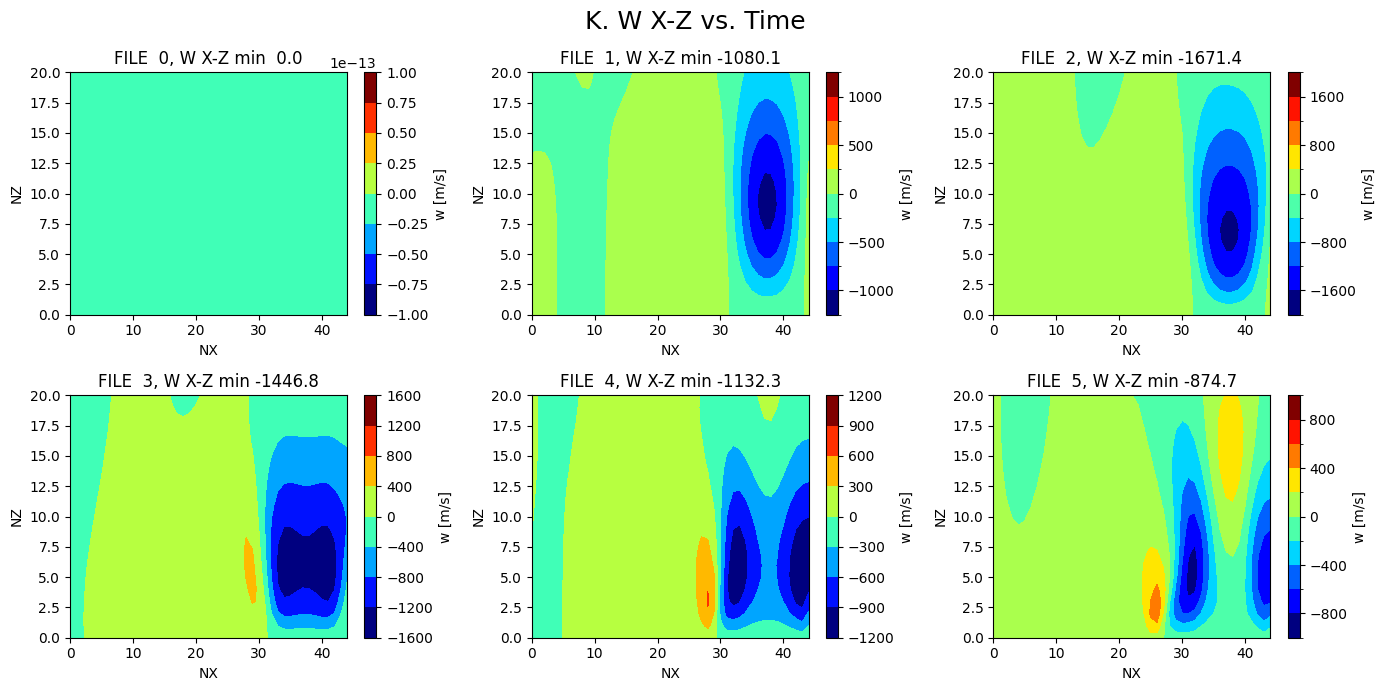

In [29]:
# >> K. VERTICAL 6-PANEL X-Z Slice Plot of W
#
#  1: DS.w[] again
#  2. for-loop n = 0 ... 5 by 1 (including time n=5!!)
#  3. subplot with (2,3,n+1)
#  4. Plot XZ plot of DS.w for time index n, 3rd (y) index=45,
#       using ':' for Z and X indices, and plot.contourf(levels=10)
#  5. Same sort of title
#  6. Add a suptitle: 'K. W X-Z vs. Time'
#  7. tight_layout again

fig = plt.figure(figsize=(14, 7))

for n in range(0, 6, 1):
  plt.subplot(2, 3, n+1)
  DS.w[n, :, 45, :].plot.contourf(levels=10, cmap='jet')
  min_w = np.min(DS.w[n, :, 45, :]).values
  plt.title(f"FILE {n:2d}, W X-Z min {min_w:4.1f}")

fig.suptitle('K. W X-Z vs. Time', fontsize=18)
plt.tight_layout()

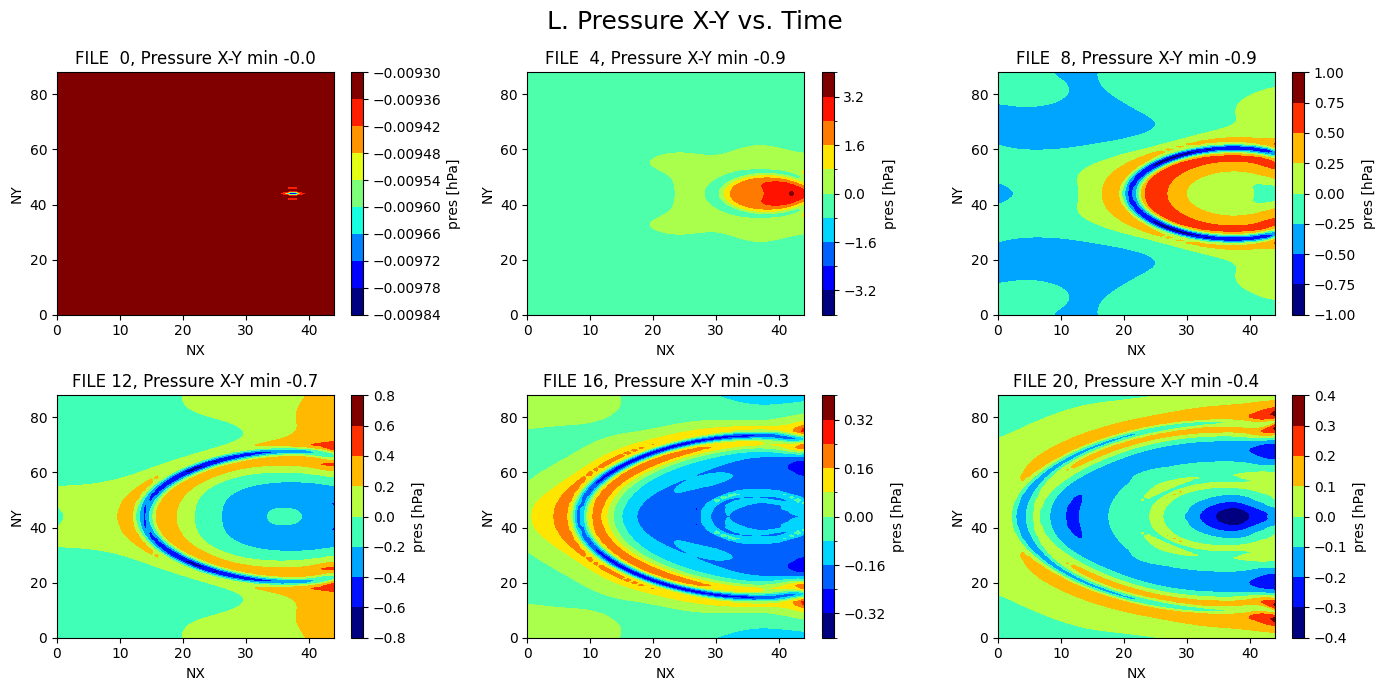

In [32]:
# >> L. ADD your OWN 6-panel PLOT
#
#   1. Do another 6-panel plot ... it just can't be one done before in this lab
#   2. You can choose the variable from list of variables at top (in cell C)
#   3. You choose the domain between X, Y, Z, and time (some variables only 2D, though)
#   4. Add a meaningful title for each panel with min or max of your variable!
#   5. Add a suptitle.

fig = plt.figure(figsize=(14, 7))

for n in range(0, 21, 4):
  plt.subplot(2, 3, int(n/4)+1)
  DS.pres[n, 0, :, :].plot.contourf(levels=10, cmap='jet')
  min_w = np.min(DS.pres[n, 0, :, :]).values
  plt.title(f"FILE {n:2d}, Pressure X-Y min {min_w:4.1f}")

fig.suptitle('L. Pressure X-Y vs. Time', fontsize=18)
plt.tight_layout()

In [ ]:
|# USE THIS cell to SAVE NOTEBOOK as HTML
# 1. LEAVE this cell COMMENTED OUT until your code works.
# 2. Still with this commented out, save notebook.ipynb file to your PC.
# 3. Upload the .ipynb file from your PC to Colab space
# 4. NOW uncomment this cell
# 5. Change filename below (after "--to html") to this notebook's name
# 6. Run JUST this cell.
# 7. Find the new .html file; Refresh the Colab file list if need be
# 8. Save (from 3-dots) the .html file to your PC.
# 9. Upload both the .ipynb and the .html files to MOODLE.
# %%shell
# jupyter nbconvert --to html  NAME